# pNEUMA dataset
https://open-traffic.epfl.ch/

## References

Emmanouil Barmpounakis, Nikolas Geroliminis,
On the new era of urban traffic monitoring with massive drone data: The pNEUMA large-scale field experiment,
Transportation Research Part C: Emerging Technologies,
Volume 111,
2020,
Pages 50-71,
ISSN 0968-090X,
https://doi.org/10.1016/j.trc.2019.11.023.

In [1]:
import os
import csv
import glob
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.2f}'.format

In [3]:
import numpy as np
import datetime as dt
import contextily as ctx
import geopandas as gpd
import movingpandas as mpd

In [28]:
from rtree import index
from datetime import timedelta
from geopandas import GeoDataFrame
from shapely.ops import nearest_points
from shapely.geometry import Point, LineString
from ipywidgets import IntSlider, interact    

In [5]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [6]:
#import hdbscan
#from pydmd import DMD

In [7]:
def read_csv(path):
    metadata_cols = [
        'track_id',
        'type',
        'traveled_d',
        'avg_speed',
    ]
    data_cols = [
        'lat',
        'lon',
        'speed',
        'lat_acc',
        'lon_acc',
        'time',
        'track_id',
    ]

    metadata_colsize = len(metadata_cols)
    data_colsize = len(data_cols) - 1

    metadata_rows = list()
    data_rows = list()

    with open(path) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=';')
        next(csv_reader)
        metadata = dict()
        for row in csv_reader:
            row = [item.strip() for item in row]
            track_id = int(row[0])
            metadata_rows.append(row[:metadata_colsize])

            data_traj = [
                float(item) for item in row[metadata_colsize:] if len(item) > 0
            ]
            for i in range(0, len(data_traj), data_colsize):
                data_row = data_traj[i:i + data_colsize] + [track_id]
                data_rows.append(data_row)

    data = pd.DataFrame(data_rows, columns=data_cols)
    metadata = pd.DataFrame(metadata_rows, columns=metadata_cols)
    metadata = metadata.set_index('track_id')
    metadata.index = metadata.index.astype(int)
    return metadata, data

In [8]:
files = []
root = os.getcwd()
path = './data/pNEUMA/'
os.chdir(path)
for file in glob.glob("*.csv"):
    files.append(file)
os.chdir(root)
urlpath = f'{path}{file}'
print(urlpath)

./data/pNEUMA/20181024_d1_0830_0900.csv


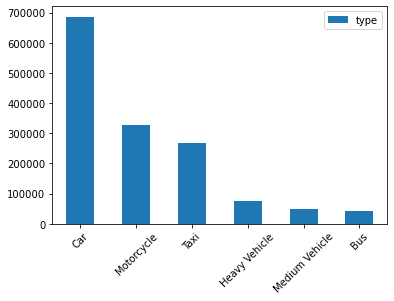

In [9]:
metadata, data = read_csv(urlpath)
df = pd.merge(metadata, data, left_index=True, right_on='track_id')
df['traveled_d'] = df.traveled_d.astype(float)
ax = df.type.value_counts(dropna=False).plot.bar(rot=45, legend=True)

In [10]:
sample = df#[(df.track_id <= 100)]
sample['timestamp'] = sample.apply(
    lambda x: dt.datetime(2018, 10, 24, 8, 30) + timedelta(seconds=x.time),
    axis=1)
sample = sample.set_index('timestamp')

In [11]:
# Initialize points in ETRS89 reference system.
geolocations = gpd.GeoDataFrame(sample,
                                geometry=gpd.points_from_xy(
                                    sample.lon,
                                    sample.lat,
                                    crs={'init': 'epsg:4326'}))
geolocations.crs

<Geographic 2D CRS: +init=epsg:4326 +type=crs>
Name: WGS 84
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [12]:
%%time
trajectories = []
for key, values in geolocations.groupby(['track_id']):
    try:
        trajectory = mpd.Trajectory(values, key)
        if trajectory.df.shape[0] > 1:
            trajectories.append(trajectory)
    except:
        pass

print("Finished creating {} trajectories".format(len(trajectories)))

Finished creating 922 trajectories
CPU times: user 1.18 s, sys: 31.7 ms, total: 1.21 s
Wall time: 1.21 s


In [14]:
traj_collection = mpd.TrajectoryCollection(trajectories[:])
print(traj_collection)

TrajectoryCollection with 922 trajectories


In [15]:
# Convert to Pseudo-Mercator for cartography.
geolocations = geolocations.to_crs(epsg=3857)
geolocations.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World - 85°S to 85°N
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [16]:
def get_locations_at_timestamps(col, t):
    pos = []
    for traj in col.trajectories:
        if t >= traj.get_start_time() and t <= traj.get_end_time():
            pos.append({
                'geometry': traj.get_position_at(t),
                'id': str(traj.id),
                'type': traj.df['type'].values[0]
            })
    return GeoDataFrame(pd.DataFrame(pos), crs=traj.crs)

In [17]:
# Extract x, y and c from geopandas.
lat = geolocations.geometry.y
lon = geolocations.geometry.x
c = geolocations.speed

In [18]:
# Specify maptiles source.
basemap = ctx.providers.CartoDB.DarkMatter

In [19]:
@interact(i=(0, geolocations.time.max(), 0.5))
def plot(i=0):
    fig, ax = plt.subplots(figsize=(20, 20))
    ax.scatter(lon, lat, c=c, s=0.05, ec=None, cmap='plasma')

    t = dt.datetime(2018, 10, 24, 8, 30) + timedelta(seconds=i)
    points = get_locations_at_timestamps(traj_collection, t)
    points = points.to_crs(epsg=3857)
    sizes = {
        'Car': 30,
        'Taxi': 30,
        'Bus' : 90,
        'Motorcycle': 5,
        'Medium Vehicle': 50,
        'Heavy Vehicle': 90
    }
    colors = {
        'Car': 'white',
        'Taxi': 'gold',
        'Bus' : 'royalblue',
        'Motorcycle': 'crimson',
        'Medium Vehicle': 'saddlebrown',
        'Heavy Vehicle': 'darkgreen'
    }
    points['sizes'] = points['type'].map(sizes)
    points['colors'] = points['type'].map(colors)
    lat1 = points.geometry.y
    lon1 = points.geometry.x
    sizes = points['sizes']
    colors = points['colors']
    ax.scatter(lon1, lat1, s=sizes, ec=None, c=colors)
    ax.set_axis_off()
    ctx.add_basemap(ax, attribution=False, source=basemap, zoom=18)

interactive(children=(FloatSlider(value=0.0, description='i', max=818.8, step=0.5), Output()), _dom_classes=('…

In [20]:
import osmnx as ox

In [21]:
from leuvenmapmatching.map.inmem import InMemMap

map_con = InMemMap("myosm", use_latlon=True)

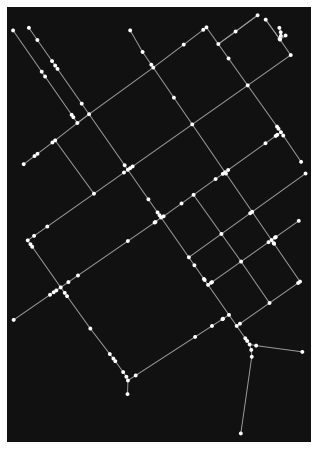

In [22]:
G = ox.graph_from_bbox(sample.lat.max(),
                       sample.lat.min(),
                       sample.lon.max(),
                       sample.lon.min(),
                       simplify=False,
                       retain_all=False,
                       truncate_by_edge=True,
                       clean_periphery = False,
                       network_type='drive')
G_projected = ox.project_graph(G)
ax = ox.plot_graph(G_projected)

In [23]:
nodes, streets = ox.graph_to_gdfs(G, nodes=True, edges=True)

In [24]:
streets.geometry.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [25]:
for nid, row in nodes[['x', 'y']].iterrows():
    map_con.add_node(nid, (row['y'], row['x']))
for u, v, _ in G.edges:
    map_con.add_edge(u, v)

In [26]:
streets = streets.to_crs(epsg=3857).reset_index()
streets['bbox'] = streets.apply(lambda row: row['geometry'].bounds, axis=1)

In [27]:
trip = traj_collection.trajectories[100].df.to_crs(epsg=3857)
trip

type  traveled_d avg_speed   lat   lon  speed  \
timestamp                                                               
2018-10-24 08:30:22.800  Car      169.41  9.932919 37.98 23.74  33.42   
2018-10-24 08:30:22.840  Car      169.41  9.932919 37.98 23.74  33.41   
2018-10-24 08:30:22.880  Car      169.41  9.932919 37.98 23.74  33.40   
2018-10-24 08:30:22.920  Car      169.41  9.932919 37.98 23.74  33.38   
2018-10-24 08:30:22.960  Car      169.41  9.932919 37.98 23.74  33.36   
...                      ...         ...       ...   ...   ...    ...   
2018-10-24 08:31:24.040  Car      169.41  9.932919 37.98 23.74   7.97   
2018-10-24 08:31:24.080  Car      169.41  9.932919 37.98 23.74   7.98   
2018-10-24 08:31:24.120  Car      169.41  9.932919 37.98 23.74   7.99   
2018-10-24 08:31:24.160  Car      169.41  9.932919 37.98 23.74   8.00   
2018-10-24 08:31:24.200  Car      169.41  9.932919 37.98 23.74   8.00   

                         lat_acc  lon_acc  time  track_id  \
timestamp                                                   
2018-10-24 08:30:22.800     0.05    -0.05 22.80       101   
2018-10-24 08:30:22.840    -0.01    -0.06 22.84       101   
2018-10-24 08:30:22.880    -0.06    -0.06 22.88       101   
2018-10-24 08:30:22.920    -0.08    -0.06 22.92       101   
2018-10-24 08:30:22.960    -0.12    -0.07 22.96       101   
...                          ...      ...   ...       ...   
2018-10-24 08:31:24.040     0.06    -0.11 84.04       101   
2018-10-24 08:31:24.080     0.04    -0.10 84.08       101   
2018-10-24 08:31:24.120     0.03    -0.09 84.12       101   
2018-10-24 08:31:24.160     0.01    -0.08 84.16       101   
2018-10-24 08:31:24.200    -0.03    -0.08 84.20       101   

                                                geometry  
timestamp                                                 
2018-10-24 08:30:22.800  POINT (2642226.223 4576375.330)  
2018-10-24 08:30:22.840  POINT (2642226.557 4576375.613)  
2018-10-24 08:30:22.880  POINT (2642227.002 4576375.754)  
2018-10-24 08:30:22.920  POINT (2642227.336 4576376.036)  
2018-10-24 08:30:22.960  POINT (2642227.781 4576376.319)  
...                                                  ...  
2018-10-24 08:31:24.040  POINT (2642397.989 4576499.468)  
2018-10-24 08:31:24.080  POINT (2642397.989 4576499.609)  
2018-10-24 08:31:24.120  POINT (2642397.877 4576499.750)  
2018-10-24 08:31:24.160  POINT (2642397.877 4576499.891)  
2018-10-24 08:31:24.200  POINT (2642397.877 4576499.891)  

[1536 rows x 11 columns]

In [35]:
def build_rtree_index_edges(gpd_edges):
    '''
    build a r-tree index for road segments
    input:
        gpd_edges: a geopandas dataframe that contains road segments (edge geometries)
    output:
        idx: a r-tree index of the edge geometries
    '''
    # r-tree index for edges
    p = index.Property()
    idx = index.Index(properties=p)
    for i, row in gpd_edges.iterrows():
        idx.insert(i, row['bbox'], obj=row)
    return idx

In [30]:
def query_k_nearest_road_segments(edge_idx, point, k):
    '''
    query k-nearest road segments of a given point
    :param edge_idx: the road segments r-tree index
    :param point: the given point
    :param k: the number of segments needed to query
    :return: k candidates as a pandas DataFrame
    '''
    candidates = pd.DataFrame(columns=('distance', 'u', 'v', 'proj_point', 'road'))
    hits = edge_idx.nearest((point.x, point.y, point.x, point.y), k, objects=True)
    for item in hits:
        results = nearest_points(point, item.object['geometry'])
        d = point.distance(results[1])
        s = pd.Series({'distance':d,
                       'u':item.object['u'], 
                       'v':item.object['v'], 
                       'proj_point':results[1],
                      'road':item.object})
        candidates = candidates.append(s, ignore_index=True)
    candidates.sort_values(by='distance', axis=0, inplace=True)
    return candidates

In [31]:
def find_candidates(trip, road_idx, k):
    '''
    given a trip, find candidates points for each point in the trip
    :param trip: a GPS trajectory (without coordinates transform)
    :param road_idx: road segments r-tree index of the corresponding road network
    :param k: the number of candidates
    :return: the trip with candidates
    '''
    candi_list = []
    for i in range(0, len(trip)):
        candidates = query_k_nearest_road_segments(road_idx, trip.iloc[i]['geometry'], k)
        candi_list.append(candidates)
    trip['candidates'] = candi_list
    return trip

In [32]:
def normal_distribution(mu, sigma, x):
    '''
    calculate normal distribution values
    input:
    mu: the mean value
    sigma; the standard deviation
    x: the given variables
    output:
    the probabilities of given input variables x
    '''
    return 1.0/(sigma * np.sqrt(2*np.pi)) * ( np.exp(-1.0 * (np.array(x)-mu)**2 / (2 * sigma**2)) )

In [33]:
def calculate_observation_probability(trip, mu, sigma):
    for i in range(len(trip)):
        trip.iloc[i]['candidates']['observation prob'] = trip.iloc[i][
            'candidates'].apply(
                lambda row: normal_distribution(mu, sigma, row['distance']),
                axis=1)
    return trip

In [36]:
k = 3
mu = 0
sigma = 10
idx = build_rtree_index_edges(streets)
traj = find_candidates(trip, idx, k)
traj = calculate_observation_probability(traj, mu, sigma)

In [37]:
traj.iloc[19]['candidates']

distance           u           v  \
0      1.67  5298481655   300398968   
1     49.55   300398968  7620257331   
2     58.04   954712456  5298481655   

                                    proj_point  \
0  POINT (2642232.660378927 4576381.671067205)   
1  POINT (2642274.168057227 4576408.673433453)   
2  POINT (2642184.032665532 4576350.036839982)   

                                                road  observation prob  
0  u                                             ...              0.04  
1  u                                             ...              0.00  
2  u                                             ...              0.00

In [38]:
proj_points = []
for candidate in traj.candidates[:]:
    proj_points.append(candidate.proj_point.ravel())

In [39]:
proj_points = np.concatenate(proj_points).ravel()
candidates = gpd.GeoDataFrame(proj_points, geometry=0)

In [40]:
# Extract x, y and c from geopandas.
lat = candidates.geometry.y
lon = candidates.geometry.x

lat2 = traj.geometry.y
lon2 = traj.geometry.x
lat1 = lat2[0]
lon1 = lon2[0]

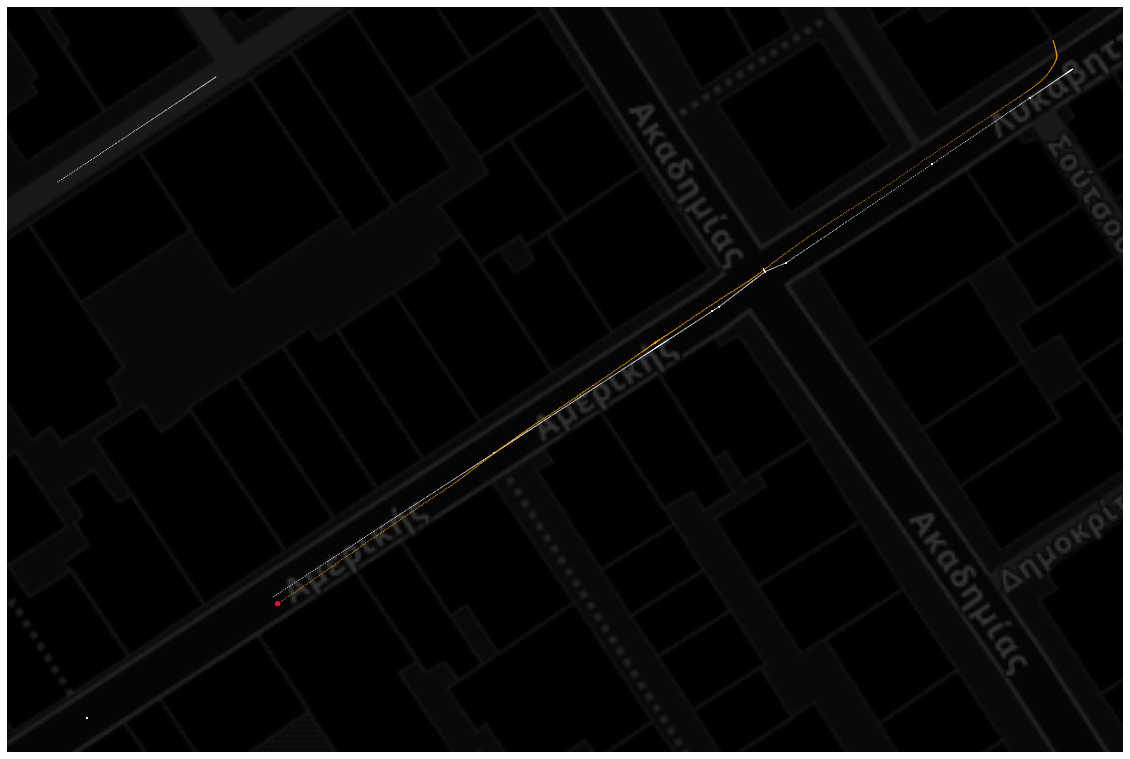

In [41]:
fig, ax = plt.subplots(figsize=(20, 20))
ax.scatter(lon, lat, s=1, ec=None, c='white')
ax.scatter(lon2, lat2, s=1, ec=None, c='orange', zorder=1)
ax.scatter(lon1, lat1, s=30, ec=None, c='crimson', zorder=2)
ax.set_axis_off()
ctx.add_basemap(ax, attribution=False, source=basemap, zoom=18)

*****************************

Lowered zoom level to keep map size reasonable. (z = 17)


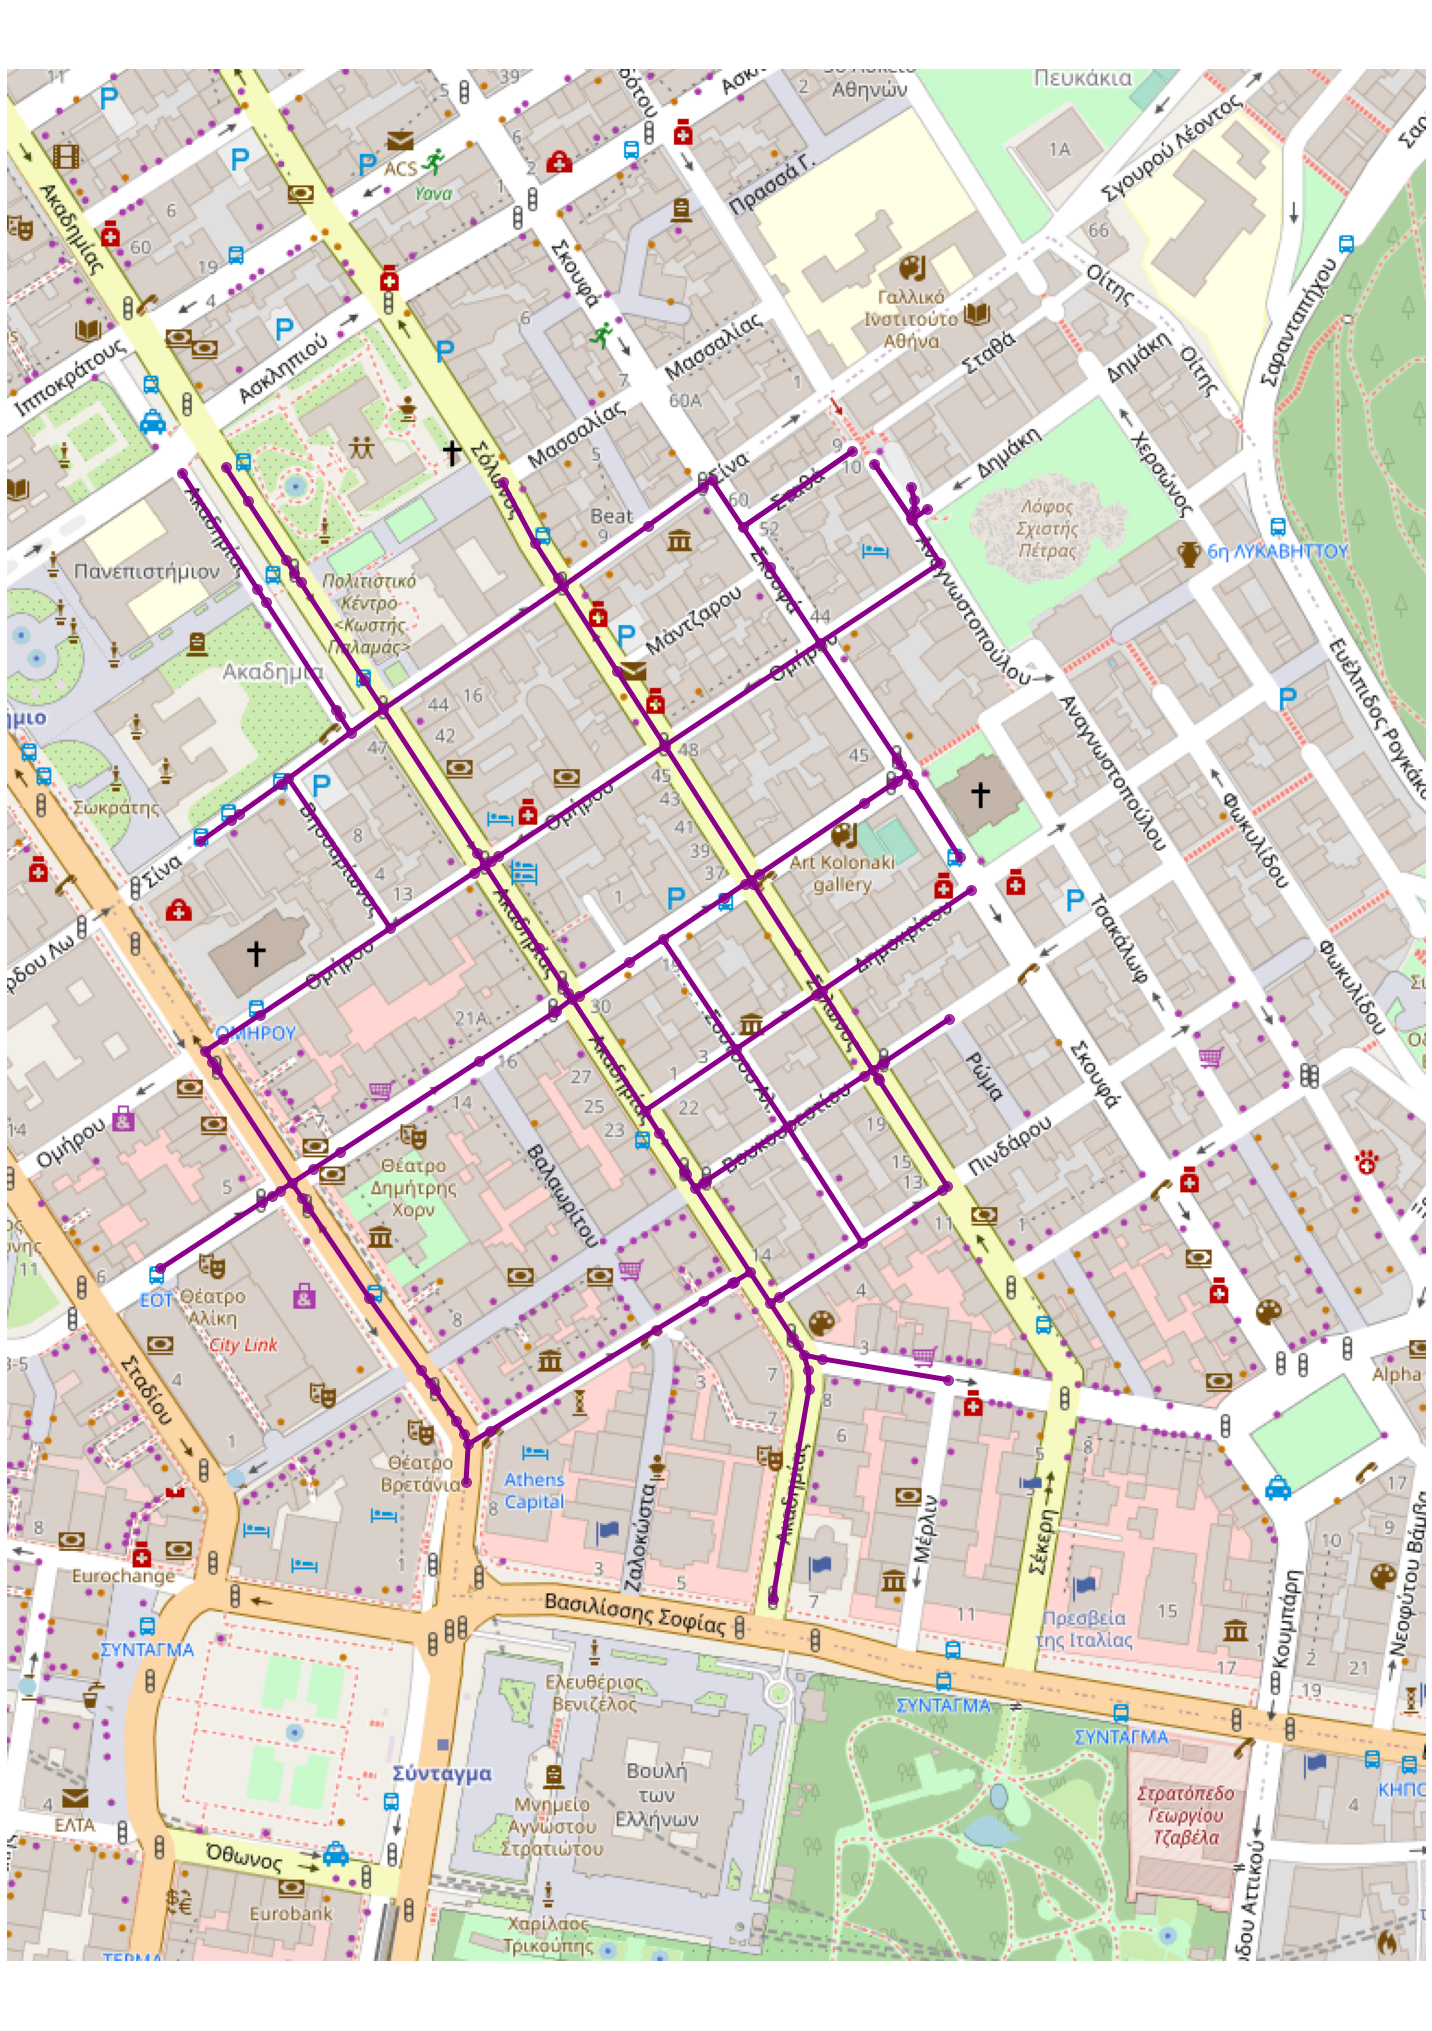

In [42]:
from leuvenmapmatching import visualization as mmviz
mmviz.plot_map(map_con,
               matcher=None,
               show_labels=False,
               show_matching=False,
               show_graph=True,
               use_osm=True,
               linewidth=5)
plt.show()

In [43]:
import folium
style = {'weight':2}
m = folium.Map([sample.lat.mean(), sample.lon.mean()],
               zoom_start=16.5,
               max_zoom=20,
               tiles='CartoDb dark_matter')
folium.GeoJson(streets.geometry, style_function=lambda x: style).add_to(m)
m